# imports

In [71]:
import os
import torch
from torch import nn
from torchvision import models
from torchsummary import summary
import torchinfo
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
import spacy
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# set the device

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# dataset hyperparameters

In [4]:
batch_num = 32
# If num_workers = 0, the data loading happens in the main process (sequentially, which can be slow)
# If num_workers > 0, PyTorch will use multiple subprocesses to load the data concurrently
workers = 0
# Set to true when using GPU to prevent copying data from host memory (CPU RAM) to device memory (GPU)
pin_memory = True

# Collate

In [60]:
# Responsible for converting the individual data items returned by the __getitem__ method of custom Dataset 
# into a single batch that can be passed to the model during training or evaluation
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # Get the image and change it's dimention [C, H, W] → [1, C, H, W]
        imgs = [item[0].unsqueeze(0) for item in batch]
        targets = [item[1] for item in batch]
        lengths = [item[2] for item in batch]
        
        # Concatenate all images along dim=0 to form a batch tensor of shape [batch_size, C, H, W]
        imgs = torch.cat(imgs, dim=0)
        # Use pad_sequence to pad variable-length sequences to the same length
        # batch_first=True argument means the output tensor has shape (batch_size, max_seq_length)
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        
        return imgs, targets, torch.tensor(lengths)

# Vocabulary

In [48]:
# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, tokens):
        frequencies = Counter()

        for cap_tokens in tokens:
            # Update word frequency
            frequencies.update(cap_tokens)

        # Get the words with frequency more than a threshold
        words = [w for w in frequencies.keys() if frequencies[w] > self.freq_threshold]
        # Use v + 4 because indexes 0 to 3 are already taken
        self.stoi.update({k: v + 4 for v, k in enumerate(words)})
        self.itos.update({v + 4: k for v, k in enumerate(words)})

    def numericalize(self, text, tokenized_text):
        # Use tokens from dataset or use spacy
        # tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def textualize(self, embedding):
        # Convert tensor to list
        embedding_list = embedding.tolist()
        return " ".join(self.itos[num] for num in embedding_list)

# load data

In [49]:
# TODO: maybe decrease the attributes of this class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, tokens, captions_per_image=5, transform=None, freq_threshold=5):
        self.image_folder = image_folder
        self.captions_per_image = captions_per_image
        self.captions_dict = self.sample_captions(captions_dict)  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.tokens = tokens
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        # + 2 to consider start and end tokens
        self.caption_lengths = [len(token) + 2 for token in self.tokens]
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        # self.vocab.build_vocabulary(self.captions)
        self.vocab.build_vocabulary(self.tokens)

    # # Based on image
    # def __len__(self):
    #     return len(self.image_names)

    # def __getitem__(self, idx):
    #     image_name = self.image_names[idx]
    #     image_path = os.path.join(self.image_folder, image_name)

    #     # Open image
    #     image = Image.open(image_path).convert("RGB")
        
    #     # Apply transformations
    #     if self.transform:
    #         image = self.transform(image)

    #     # Get all captions for the image
    #     captions = self.captions_dict[image_name]

    #     # Get one of the captions randomly for training
    #     random_idx = random.randrange(len(captions))
    #     caption = captions[random_idx]
    #     caption_length = self.caption_lengths[random_idx]
        
    #     numericalized_caption = [self.vocab.stoi["<start>"]]
    #     numericalized_caption += self.vocab.numericalize(caption, self.tokens[idx * self.captions_per_image + random_idx])
    #     numericalized_caption.append(self.vocab.stoi["<end>"])
    #     numericalized_caption = torch.tensor(numericalized_caption)

    #     return image, numericalized_caption, caption_length

    # Based on caption
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        image_name = self.image_names[idx // self.captions_per_image]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        caption = self.captions[idx]

        caption_length = self.caption_lengths[idx]
        
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption, self.tokens[idx])
        numericalized_caption.append(self.vocab.stoi["<end>"])
        numericalized_caption = torch.tensor(numericalized_caption)

        # Also return length and all captions for validation or testing ?
        return image, numericalized_caption, caption_length

    def sample_captions(self, img_captions):
        # Set a specific number of captions for all images
        modified_captions_dict = {}
        for img, captions in img_captions.items():
            if len(captions) < self.captions_per_image:
                new_captions = captions + [random.choice(captions) for _ in range(self.captions_per_image - len(captions))]
            else:
                new_captions = random.sample(captions, k=self.captions_per_image)
            
            # Sanity check
            assert len(new_captions) == self.captions_per_image
            modified_captions_dict[img] = new_captions        
            
        return modified_captions_dict

In [50]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
image_folder = "/kaggle/input/flickr8kimagescaptions/flickr8k/images/"
# karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr8k.json"

In [57]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}
token_data = {"train": [], "val": [], "test": []}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions
    split_data[split][image_name] = captions  # Store in respective split
    
    tokens = [sent["tokens"] for sent in img["sentences"]]  # Extract all tokens
    token_data[split] += tokens

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [61]:
# Load different splits
train_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["train"], 
    token_data["train"], 
    captions_per_image=5,
    transform=transform, 
    freq_threshold=3
)
val_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["val"], 
    token_data["val"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)
test_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["test"], 
    token_data["test"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=3
)

pad_idx = train_dataset.vocab.stoi["<pad>"]
# Create DataLoaders
train_loader = DataLoader(train_dataset, 
                          collate_fn=MyCollate(pad_idx=pad_idx), 
                          batch_size=batch_num, 
                          shuffle=True, 
                          num_workers=workers,
                          pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, 
                        collate_fn=MyCollate(pad_idx=pad_idx), 
                        batch_size=batch_num, 
                        shuffle=False, 
                        num_workers=workers,
                        pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, 
                         collate_fn=MyCollate(pad_idx=pad_idx), 
                         batch_size=batch_num, 
                         shuffle=False, 
                         num_workers=workers, 
                         pin_memory=pin_memory)

# visualize data

Batch Size: 32
Image Tensor Shape: torch.Size([32, 3, 256, 256])
First Caption: tensor([   1,  178,   11, 1378,  295,   41,    4,  562,   30, 1376,   74,    4,
          29,   30,   31,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
First caption converted: <start> girls in bikinis are playing a game of volleyball near a body of water <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


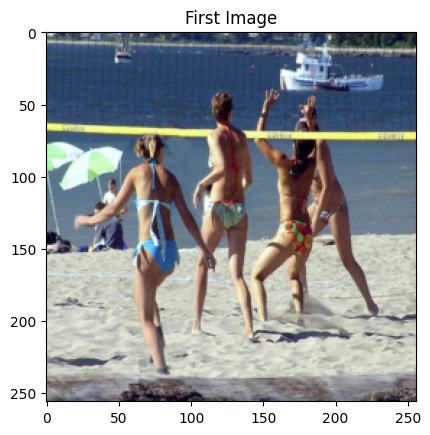

In [11]:
# Test the dataloader
# Fetch one batch
images, captions = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]
image = images[0].permute(1, 2, 0).numpy()
image = image * 0.225 + 0.45  # De-normalize
plt.title("First Image")
plt.imshow(image)
print(f"First Caption: {captions[0]}")
text_caption = train_dataset.vocab.textualize(captions[0])
print(f"First caption converted: {text_caption}")

In [12]:
def get_all_caps(dataset, idx):
    image_name = dataset.image_names[idx]
    return dataset.captions_dict[image_name]

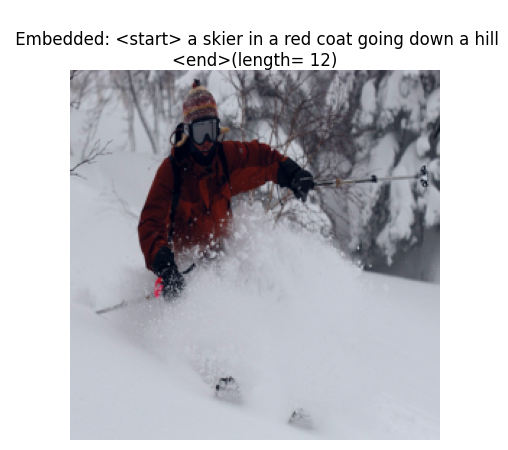

In [16]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption, caption_length = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    text_caption = dataset.vocab.textualize(caption)
    # all_caps = "\n".join(get_all_caps(dataset, idx))
    plt.imshow(image)
    # Use this when the idx is for images not captios
    # plt.title(all_caps + '\n Embedded:' + text_caption, fontsize=12, wrap=True)
    plt.title(f'\n Embedded: {text_caption}(length= {str(caption_length)})', fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

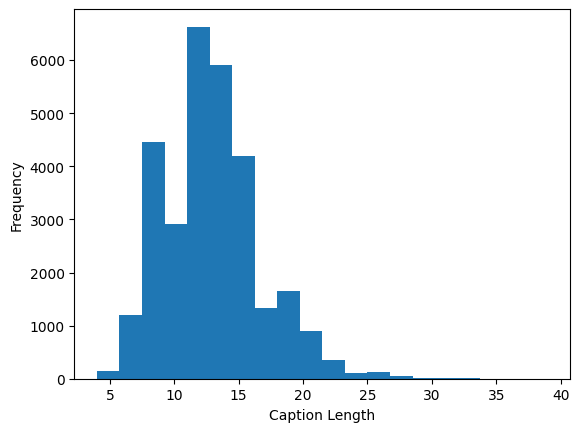

In [17]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


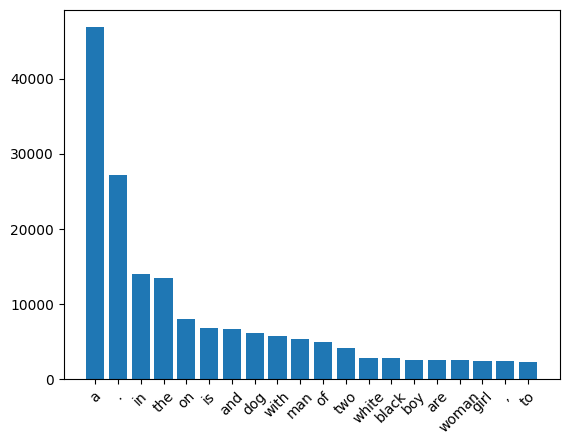

In [18]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# model

In [22]:
# model = models.resnet101(pretrained=True)
# # model = models.vgg16(pretrained=True) 
# # model = models.maxvit_t(pretrained=True) 
# # model = models.efficientnet_b0(pretrained=True)
# # model = models.inception_v3(pretrained=True)

# # model = models.mobilenet_v3_small(pretrained=True)
# # model = models.densenet201(pretrained=True)
# print(torchinfo.summary(model, input_size=(4, 3, 256, 256)))

In [23]:
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"Total Parameters: {total_params:,}")
# print(f"Trainable Parameters: {trainable_params:,}")

# for name, layer in model.named_children():
#     print(name, ":", layer)

In [93]:
# feature extractor
class Encoder(nn.Module):
    def __init__(self, fine_tune=True):
        super(Encoder, self).__init__()
        self.fine_tune = fine_tune
        model = models.resnet101(pretrained=True)

        # model = models.vgg16(pretrained=True) 
        # model = models.inception_v3(pretrained=True)
        # model = models.maxvit_t(pretrained=True) 
        # model = models.efficientnet_b0(pretrained=True)
        
        # Remove linear and pool layers (since we're not doing classification)
        modules = list(model.children())[:-2]
        # nn.Sequential allows you to chain layers together without writing a forward pass manually
        self.model = nn.Sequential(*modules)
        self.set_grad()
    
    def forward(self, images):
        x = self.model(images) # (batch_size, 2048, image_size/32, image_size/32) => [4, 2048, 8, 8]
        x = x.permute(0, 2, 3, 1)
        return x
        
    def set_grad(self):
        # UNFREEZE only the last few layers (4th ResNet block)
        for name, param in self.model.named_parameters():
            if "layer4" in name:  # Last residual block (closest to output)
                param.requires_grad = self.fine_tune  # Trainable
            else:
                param.requires_grad = False  # Frozen
        

In [20]:
model = Encoder()
print(model(torch.randn(1, 3, 256, 256)).shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 168MB/s]  


torch.Size([1, 8, 8, 2048])


In [29]:
# attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
    
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out => (batch_size, num_pixels, encoder_dim)
        # decoder_hidden => (batch_size, decoder_dim)
        att1 = self.encoder_att(encoder_out) # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2) # (batch_size, num_pixels)
        # attention weights
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

In [24]:
# model = Attention(encoder_dim=2048, decoder_dim=)
# print(model(torch.randn(1, 3, 256, 256)).shape)

In [65]:
# word generator
# I have problem understanding this class
class Decoder(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout=0.5):
        super(Decoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.attention_dim = attention_dim
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.dropout = dropout
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # ???????????????????????
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.gate_linear = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate

        self.lstm_cell = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)  # decoding LSTMCell
        # Dropout randomly zeroes out some elements of input with probability p
        self.dropout = nn.Dropout(p=self.dropout)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
    #     self.init_weights()  # initialize some layers with the uniform distribution for easier convergence

    # def init_weights(self):
    #     self.embedding.weight.data.uniform_(-0.1, 0.1)
    #     self.fc.bias.data.fill_(0)
    #     self.fc.weight.data.uniform_(-0.1, 0.1)
    
    def forward(self, encoder_out, embedded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        # Flatten image (num_pixels = H * W)
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        
        # Sort input data by decreasing lengths
        caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        embedded_captions = embedded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(embedded_captions)  # (batch_size, max_caption_length, embed_dim)

        # why not 0??????????
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()
        
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for word_num in range(max(decode_lengths)):
            inner_batch_size = sum([l > word_num for l in decode_lengths])
            
            attention_weighted_encoding, alpha = self.attention(encoder_out[:inner_batch_size], h[:inner_batch_size])

            # the model dynamically decides how much attention matters for each word prediction
            gate = self.sigmoid(self.gate_linear(h[:inner_batch_size]))  # gating scalar between 0 and 1, (inner_batch_size, encoder_dim) 
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # input, h0, c0 => h1, c1
            h, c = self.lstm_cell(
                torch.cat([embeddings[:inner_batch_size, word_num, :], attention_weighted_encoding], dim=1),
                (h[:inner_batch_size], c[:inner_batch_size]))  # (inner_batch_size, decoder_dim)
            # Without dropout, the model might overfit to certain word sequence
            preds = self.fc(self.dropout(h))  # (inner_batch_size, vocab_size)
            predictions[:inner_batch_size, word_num, :] = preds
            alphas[:inner_batch_size, word_num, :] = alpha

        return predictions, alphas, sort_ind, embedded_captions, decode_lengths

# Model parameters

In [66]:
# Model parameters
# decoder
# 512 initially but set to 256 for smaller dataset and not good device speed
embed_dim = 256  # dimension of word embeddings
attention_dim = 256  # dimension of attention linear layers
decoder_dim = 256  # dimension of decoder RNN
dropout = 0.5
vocab_size = len(train_dataset.vocab)
encoder_dim = 2048
# encoder
fine_tune_encoder = False

encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
# Higher value because it has been made from scratch
decoder_lr = 4e-4  # learning rate for decoder

In [94]:
encoder = Encoder(fine_tune_encoder).to(device)
decoder = Decoder(encoder_dim, decoder_dim, attention_dim, vocab_size, embed_dim, dropout).to(device)

# loss and optimizer

In [95]:
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add Checkpoint

In [32]:
# # here
# if val_loss < best_val_loss:
#     best_val_loss = val_loss
#     torch.save(checkpoint, 'best_checkpoint.pth')

# # or here
# if epoch % 5 == 0:  # Save checkpoint every 5 epochs
#     torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')

# Teacher forcing

# Beam search

# Training parameters

In [100]:
epochs = 1
checkpoint_path = None # path to checkpoint 
print_freq = 10

# train

In [101]:
def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    # Performs one epoch's training.

    decoder.train()  # train mode (dropout and batchnorm is used)
    encoder.train()

    # Batches
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # Forward prop.
        imgs = encoder(imgs)
        scores, alphas, sort_ind, captions_sorted, decode_lengths = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = captions_sorted[:, 1:]

        # Remove the padding, keep track of the sequence lengths, 
        # Pass the packed sequence to the model, so it only processes the valid parts of each sequence
        scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores, targets)

        # Back prop.
        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        # Update weights
        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        # Print status
        if i % print_freq == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t ,loss: {loss}')

In [ ]:
if checkpoint_path:
    # Loading checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    
    encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

for epoch in range(epochs):
    # One epoch's training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch)

    # One epoch's validation
    # recent_bleu4 = validate(val_loader=val_loader,
    #                         encoder=encoder,
    #                         decoder=decoder,
    #                         criterion=criterion)
    
    # Saving checkpoint
    checkpoint = {
        'epoch': epoch,  # Save current epoch
        'encoder_state_dict': encoder.state_dict(),  # Save encoder weights
        'decoder_state_dict': decoder.state_dict(),  # Save decoder weights
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict() if encoder_optimizer else None,
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'loss': loss,  # Save the last recorded loss
    }
    
    torch.save(checkpoint, 'checkpoint.pth')
    

Epoch: [0][0/938]	 ,loss: 7.384347438812256
Epoch: [0][10/938]	 ,loss: 6.170107841491699
Epoch: [0][20/938]	 ,loss: 5.694349765777588
Epoch: [0][30/938]	 ,loss: 5.465412616729736
Epoch: [0][40/938]	 ,loss: 5.251410961151123
Epoch: [0][50/938]	 ,loss: 5.016977310180664
Epoch: [0][60/938]	 ,loss: 5.138248443603516
Epoch: [0][70/938]	 ,loss: 4.990337371826172
Epoch: [0][80/938]	 ,loss: 4.928984642028809
Epoch: [0][90/938]	 ,loss: 5.030177116394043
Epoch: [0][100/938]	 ,loss: 4.868608474731445
Epoch: [0][110/938]	 ,loss: 5.085346698760986
Epoch: [0][120/938]	 ,loss: 4.843670845031738
Epoch: [0][130/938]	 ,loss: 4.890609264373779
Epoch: [0][140/938]	 ,loss: 4.706068515777588
Epoch: [0][150/938]	 ,loss: 4.562358856201172
Epoch: [0][160/938]	 ,loss: 4.664194583892822
Epoch: [0][170/938]	 ,loss: 4.78819465637207
Epoch: [0][180/938]	 ,loss: 4.634279727935791
Epoch: [0][190/938]	 ,loss: 4.3876423835754395
Epoch: [0][200/938]	 ,loss: 4.2412872314453125
Epoch: [0][210/938]	 ,loss: 4.67541456222534

In [88]:
padded_sequences = torch.tensor([ 
    [6, 7, 8, 9], 
    [1, 2, 3, 0],  
    [4, 5, 0, 0]  
])

packed = pack_padded_sequence(padded_sequences, [4, 3, 2], batch_first=True)
print(packed)

PackedSequence(data=tensor([6, 1, 4, 7, 2, 5, 8, 3, 9]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)


# validate

# Test

# Test on your own data

# TTS

# Save outputs for next time

In [ ]:
!zip -r saved_data.zip /kaggle/working/